In [1]:
import os

os.chdir('../')
print(os.getcwd())

/app


In [3]:
import argparse
import os
import ruamel.yaml as yaml
import numpy as np
import random
from pathlib import Path
import importlib
import json
import tensorflow as tf
import tensorflow_hub as hub
from models.blip_pretrain import blip_pretrain
import sys
sys.path.append('../cleverhans')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.backends.cudnn as cudnn
from models.blip_vqa import blip_vqa
import utils
os.chdir('/app/BLIP_attack')
print(os.getcwd())
from data import create_dataset, create_sampler, create_loader
from data.vqa_dataset import vqa_collate_fn
from transformers import BertTokenizer

ModuleNotFoundError: No module named 'models.med'

In [13]:
# 参数配置
args = {
    'config_pre': './configs/pretrain.yaml',
    'config': './configs/vqa.yaml',
    'output_dir': 'output/VQA',
    'correct_idx_store': 'right_vqa_list.txt',
    'USE_model_path': 'https://tfhub.dev/google/universal-sentence-encoder-large/5',
    'correct_pred_store': 'right_vqa_ans_table.txt',
    'method': 'BERTAttack',  # 可以切换为 BSA, Co-Attack, VLAttack 等
    'device': 'cuda:0',
    'seed': 42,
    'distributed': False
}

# 加载配置文件
config = yaml.load(open(args['config'], 'r'), Loader=yaml.Loader)
config_pretrain = yaml.load(open(args['config_pre'], 'r'), Loader=yaml.Loader)

# 输出目录设置
os.makedirs(args['output_dir'], exist_ok=True)
os.makedirs(os.path.join(args['output_dir'], 'result'), exist_ok=True)
print('Finished')


Finished


In [15]:
device = torch.device(args['device'])
print(f"Device: {device}")

Device: cuda:0


In [16]:
# 创建模型
def create_models(config, config_pretrain, device):
    model = blip_vqa(
        pretrained=config['pretrained'],
        image_size=config['image_size'],
        vit=config['vit'],
        vit_grad_ckpt=config['vit_grad_ckpt'],
        vit_ckpt_layer=config['vit_ckpt_layer']
    ).to(device)

    pretrain_model = blip_pretrain(
        pretrained=config_pretrain['pretrained'],
        image_size=config_pretrain['image_size'],
        vit=config_pretrain['vit'],
        vit_grad_ckpt=config['vit_grad_ckpt'],
        vit_ckpt_layer=config_pretrain['vit_ckpt_layer'],
        queue_size=config_pretrain['queue_size']
    ).to(device)

    return model, pretrain_model

model, pretrain_model = create_models(config, config_pretrain, device)
# 确保模型在 GPU 上
model = model.to('cuda:0')

FileNotFoundError: [Errno 2] No such file or directory: 'BLIP_attack/configs/med_config.json'

In [ ]:
#Test with benign imaged

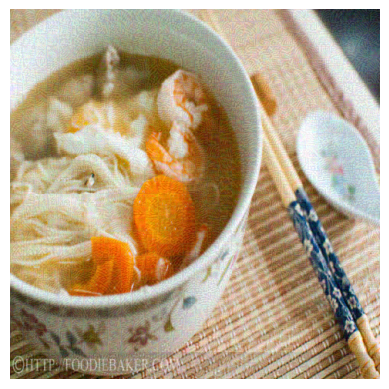

In [15]:
from PIL import Image
from torchvision import transforms
# 图像预处理
image_path = '../393225001_adversarial.png'
#image_path = '../393225001_original.png'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0)
image_tensor = image_tensor.to('cuda:0')

# 显示图像
plt.imshow(image)
plt.axis("off")
plt.show()

In [16]:
from models.blip import init_tokenizer

# 示例问题
question = "is this a creamy soup?"
tokenizer = init_tokenizer()


# 编码问题
#question_input = tokenizer(
    #question, padding='longest', truncation=True, max_length=35, return_tensors="pt"
#)
#print(question_input)

In [17]:
##Use Rank model

In [18]:
# 候选答案
candidate_answers = ["yes", "no", "car"]

# 编码候选答案
answer_tokens = tokenizer(candidate_answers, padding='longest', return_tensors="pt")

# 将张量移动到正确的设备上
answer_tokens = answer_tokens.to(image_tensor.device)

with torch.no_grad():
    max_ids, topk_ids, topk_probs = model(
        image=image_tensor,
        question=question,
        answer=answer_tokens,  # 传入编码后的答案
        train=False,           # 设置为推理模式
        inference='rank',
        k_test=3
    )
    predicted_answer = [candidate_answers[idx] for idx in max_ids.cpu().numpy()]
print(f"Predicted Answer: {predicted_answer}")


Predicted Answer: ['yes']


In [19]:
##Use generate model

In [20]:
# 编码候选答案
answer_tokens = tokenizer(candidate_answers, padding='longest', return_tensors="pt")
answer_tokens = answer_tokens.to(image_tensor.device)

with torch.no_grad():
    answer = model(
        image=image_tensor,
        question=question, 
        train=False,           # 设置为推理模式
        inference='generate',
    )
print(f"Predicted Answer: {answer}")


Predicted Answer: ['yes']


In [21]:
# Tets with adversarial attacked images

In [31]:
import os
print(os.getcwd())

/app/BLIP_attack


In [60]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    
# 从本地JSON文件解析数据
json_file_path = 'adversarial_examples.json'
with open(json_file_path, 'r') as f:
    entries = [json.loads(line) for line in f.readlines()]

In [ ]:
#如果输入都是benign，模型输出和原始答案基本一样

In [65]:
results = []

for i, entry in enumerate(entries):
    #print(entry)
    image_path = entry['original_image_path']
    question = entry['original_question']
    expected_answer = entry['original_answer']

    # 加载图像
    image_tensor = load_image(image_path)

    # 使用模型进行预测
    predicted_answers = model(image=image_tensor, question=question, train=False, inference='generate')
    predicted_answer = predicted_answers[0]

    # 比较预测结果与预期答案
    result = {
        "question_id": entry['question_id'],
        "question": question,
        "expected_answer": expected_answer,
        "predicted_answer": predicted_answer,
        "correct": predicted_answer.lower() == expected_answer.lower()
    }
    results.append(result)
    if i == 9:
        break
        

# 输出结果
for result in results:
    print(f"QID: {result['question_id']} | Question: {result['question']} | Expected: {result['expected_answer']} | Predicted: {result['predicted_answer']} | Correct: {result['correct']}")


QID: 262148000 | Question: where is he looking? | Expected: down | Predicted: down | Correct: True
QID: 393225001 | Question: is this a creamy soup? | Expected: no | Predicted: yes | Correct: False
QID: 393226000 | Question: what is the man doing in the street? | Expected: walking | Predicted: walking | Correct: True
QID: 393226001 | Question: how many photo's can you see? | Expected: 1 | Predicted: 1 | Correct: True
QID: 393226002 | Question: what does the truck on the left sell? | Expected: ice cream | Predicted: ice cream | Correct: True
QID: 240301001 | Question: is it daylight in this picture? | Expected: yes | Predicted: yes | Correct: True
QID: 240301002 | Question: why is the cow laying down? | Expected: tired | Predicted: tired | Correct: True
QID: 131089000 | Question: what color is the grass in this picture? | Expected: green | Predicted: green | Correct: True
QID: 131089003 | Question: is there a chain link fence in the image? | Expected: no | Predicted: no | Correct: True


In [64]:
#result:9/10

In [ ]:
#如果text, image都是attacked，模型的输出应该和原始答案不同

In [66]:
results = []
for i, entry in enumerate(entries):
    image_path = entry['adversarial_image_path']
    question = entry['adversarial_question']
    expected_answer = entry['original_answer']

    # 加载图像
    image_tensor = load_image(image_path)

    # 使用模型进行预测
    predicted_answers = model(image=image_tensor, question=question, train=False, inference='generate')
    predicted_answer = predicted_answers[0]

    # 比较预测结果与预期答案
    result = {
        "question_id": entry['question_id'],
        "question": question,
        "expected_answer": expected_answer,
        "predicted_answer": predicted_answer,
        "correct": predicted_answer.lower() == expected_answer.lower()
    }
    results.append(result)
    if i == 9:
        break
        

# 输出结果
for result in results:
    print(f"QID: {result['question_id']} | Question: {result['question']} | Expected: {result['expected_answer']} | Predicted: {result['predicted_answer']} | Correct: {result['correct']}")


QID: 262148000 | Question: where is he looking? | Expected: down | Predicted: up | Correct: False
QID: 393225001 | Question: is this a creamy soup? | Expected: no | Predicted: yes | Correct: False
QID: 393226000 | Question: what is the man doing in the street? | Expected: walking | Predicted: crossing street | Correct: False
QID: 393226001 | Question: how many photo's can you see ! | Expected: 1 | Predicted: 1 | Correct: True
QID: 393226002 | Question: what does the truck on the left sell ! | Expected: ice cream | Predicted: ice cream | Correct: True
QID: 240301001 | Question: is it daylight in this picture? | Expected: yes | Predicted: no | Correct: False
QID: 240301002 | Question: why is the cow laying it ! | Expected: tired | Predicted: it's tired | Correct: False
QID: 131089000 | Question: what color is the grass in this picture ; | Expected: green | Predicted: green | Correct: True
QID: 131089003 | Question: is there a chain link fence in the image? | Expected: no | Predicted: yes

In [ ]:
result: 7/10

In [ ]:
# benign image, attacked text，结果如果不同则为识别为adversarial example

In [69]:
results = []
for i, entry in enumerate(entries):
    #print(entry)
    image_path = entry['original_image_path']
    question = entry['adversarial_question']
    expected_answer = entry['original_answer']

    # 加载图像
    image_tensor = load_image(image_path)

    # 使用模型进行预测
    predicted_answers = model(image=image_tensor, question=question, train=False, inference='generate')
    predicted_answer = predicted_answers[0]

    # 比较预测结果与预期答案
    result = {
        "question_id": entry['question_id'],
        "question": question,
        "expected_answer": expected_answer,
        "predicted_answer": predicted_answer,
        "correct": predicted_answer.lower() == expected_answer.lower()
    }
    results.append(result)
    if i == 9:
        break
        

# 输出结果
for result in results:
    print(f"QID: {result['question_id']} | Question: {result['question']} | Expected: {result['expected_answer']} | Predicted: {result['predicted_answer']} | Correct: {result['correct']}")


QID: 262148000 | Question: where is he looking? | Expected: down | Predicted: down | Correct: True
QID: 393225001 | Question: is this a creamy soup? | Expected: no | Predicted: yes | Correct: False
QID: 393226000 | Question: what is the man doing in the street? | Expected: walking | Predicted: walking | Correct: True
QID: 393226001 | Question: how many photo's can you see ! | Expected: 1 | Predicted: 1 | Correct: True
QID: 393226002 | Question: what does the truck on the left sell ! | Expected: ice cream | Predicted: ice cream | Correct: True
QID: 240301001 | Question: is it daylight in this picture? | Expected: yes | Predicted: yes | Correct: True
QID: 240301002 | Question: why is the cow laying it ! | Expected: tired | Predicted: it's tired | Correct: False
QID: 131089000 | Question: what color is the grass in this picture ; | Expected: green | Predicted: gray | Correct: False
QID: 131089003 | Question: is there a chain link fence in the image? | Expected: no | Predicted: no | Correc

In [24]:
class BlackBoxAttack:
    def __init__(self, black_model, answer_list, device):
        """
        初始化黑盒攻击相关的配置
        :param black_model: 黑盒模型，用于预测答案
        :param answer_list: 答案列表，用于将预测索引映射到文本答案
        :param device: 设备配置（CPU 或 GPU）
        """
        self.black_model = black_model
        self.answer_list = answer_list
        self.device = device

    def black_box_predict(self, image, text):
        """
        调用黑盒模型进行预测，返回答案
        :param image: 输入图像
        :param text: 输入问题
        :return: 预测的答案
        """
        # 调用黑盒模型，获取预测结果
        answer_ids, topk_ids, topk_probs = self.black_model(
            image, text, self.answer_candidates, train=False, inference='rank', k_test=128
        )

        # 映射预测的答案
        out_v = []
        for answer_id in answer_ids:
            out_v.append({"answer": self.answer_list[answer_id]})

        # 返回第一个答案
        return out_v[0]['answer']


In [14]:
# 加载答案列表
with open('right_vqa_ans_table.txt', 'r') as f:
    answer_list = json.load(f)
# 加载模型
black_model = model

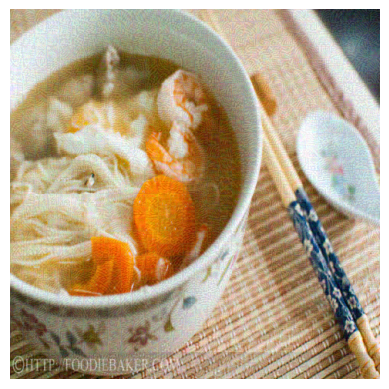

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = "../393225001_adversarial.png"  # 替换为你的图像路径
image = Image.open(image_path)

# 显示图像
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
# 候选答案
candidate_answers = ["yes", "no", "car"]

# 编码候选答案
answer_tokens = tokenizer(candidate_answers, padding='longest', return_tensors="pt")

# 将张量移动到正确的设备上
answer_tokens = answer_tokens.to(image_tensor.device)

with torch.no_grad():
    max_ids, topk_ids, topk_probs = model(
        image=image_tensor,
        question=question,
        answer=answer_tokens,  # 传入编码后的答案
        train=False,           # 设置为推理模式
        inference='rank',
        k_test=3
    )
    predicted_answer = [candidate_answers[idx] for idx in max_ids.cpu().numpy()]
print(f"Predicted Answer: {predicted_answer}")


In [17]:
# 初始化攻击对象
attack = BlackBoxAttack(black_model, answer_list, device)
# 调用 black_box_predict
test_question = 'is this a creamy soup?'
test_image = image

predicted_answer = attack.black_box_predict(test_image, test_question)
print(f"Predicted Answer: {predicted_answer}")

AttributeError: 'BlackBoxAttack' object has no attribute 'answer_candidates'